# ***VAE for image generation***
Consider VAE model from
*Auto-Encoding Variational Bayes (2014, D.P. Kingma et. al.)*.  
We will implement a VAE model using Torch and apply it to the MNIST dataset.


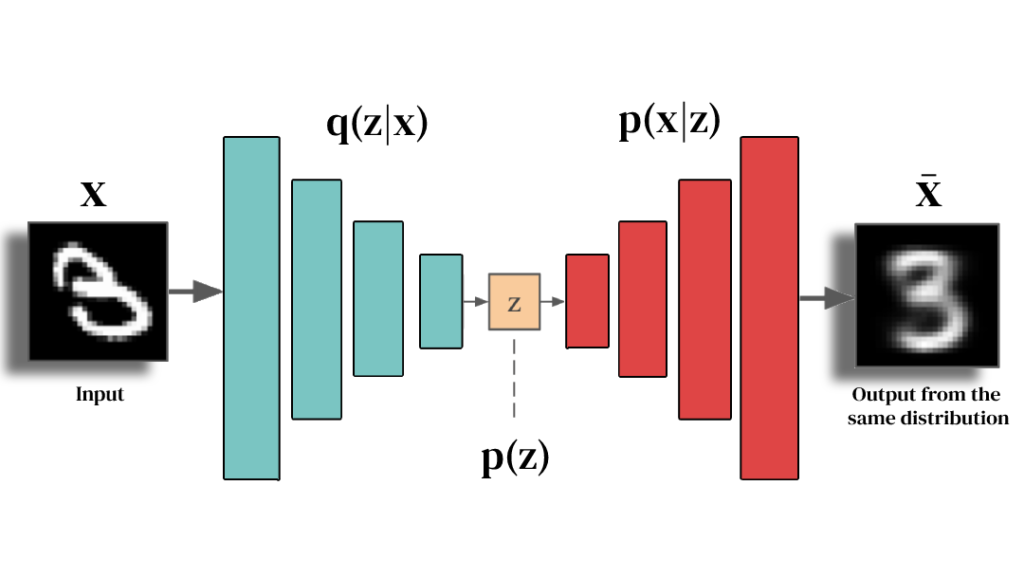


**Generative model:** We model each pixel value $\in \{0,1\}$ as a sample drawn from a Bernoulli distribution. Through a decoder, the latent random variable $z_n$  associated with an image $n$ is mapped to the success parameters of the Bernoulli distributions associated with the pixels of that image. Our generative model is described as follows:

$ z_n \sim N(0,I) $

$ \theta_n = g(z_n) $

$ x_n \sim Bern(\theta_n) $

where $g$ is the decoder. We choose the prior on $z_n$ to be the standard multivariate normal distribution, for computational convenience.  

**Inference model:** We infer the posterior distribution of $z_n$ via variational inference. The variational distribution $ q(z_n|x_n) $ is chosen to be multivariate Gaussian with a diagonal covariance matrix. The mean and covariance of this distribution are obtained by applying an encoder to $x_n$.

$ q(z_n|x_n) \sim q( \mu_n, \sigma^2_n) $

where $ \mu_n, \sigma^2_n = f(x_n)  $ and $f$ is the encoder.






**Implementation:**
Let's start with importing Torch and other necessary libraries:

In [431]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

### ***Step1: Model Hyperparameters***



In [432]:
dataset_path = '~/datasets'

batch_size = 100

# Dimensions of the input, the hidden layer, and the latent space.
x_dim  = 784
hidden_dim = 400
latent_dim = 200

# Learning rate
lr = 1e-3

# Number of epoch
epochs = 5 # can try something greater if you are not satisfied with the results

### ***Step2: Load Dataset***



In [433]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
test_labels = test_dataset.targets

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

# for i in range(10):
#     img, label = train_dataset[i]
#     plt.imshow(img.squeeze())
#     plt.show()

### ***Step3: Define the model***


In [434]:
class Encoder(nn.Module):
    # encoder outputs the parameters of variational distribution "q"
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_enc1 = nn.Linear(input_dim, hidden_dim) # FC stands for a fully connected layer
        self.FC_enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var  = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # will use this to add non-linearity to our model

        self.training = True

    def forward(self, x):
        h_1     = self.LeakyReLU(self.FC_enc1(x))
        h_2     = self.LeakyReLU(self.FC_enc2(h_1))
        mean    = self.FC_mean(h_2)  # mean
        log_var = self.FC_var(h_2)   # log of variance

        return mean, log_var

In [435]:
class Decoder(nn.Module):
    # decoder generates the success parameter of each pixel
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_dec1   = nn.Linear(latent_dim, hidden_dim)
        self.FC_dec2   = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # again for non-linearity

    def forward(self, z):
        h_out_1  = self.LeakyReLU(self.FC_dec1(z))
        h_out_2  = self.LeakyReLU(self.FC_dec2(h_out_1))

        theta = torch.sigmoid(self.FC_output(h_out_2))
        return theta


**Q3.1 (2 points)**  Below implement the reparameterization function.

In [436]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        # insert your code here
        epsilon = torch.randn_like(var)  # Random noise
        z =  mean + torch.sqrt(var) * epsilon
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(log_var)) # takes exponential function (log var -> var)

        theta = self.Decoder(z)

        return theta, mean, log_var, z

### ***Step4: Model initialization***


In [437]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder)

### ***Step5: Loss function and optimizer***


Our objective function is ELBO:
$E_{q(z|x)}\big[\log \frac{p(x,z)}{q(z|x)}\big]$

* **Q5.1 (1 point)** Show that ELBO can be rewritten as :

  $E_{q(z|x)}\big(\log p(x|z)\big) - D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$


*5.1 Your answer*

. $E_{q(z|x)}[log \frac{p(x,z)}{q(z|x)}] = E_{q(z|x)}[log \frac{p(x|z)p(z)}{q(z|x)}]$

.$= E_{q(z|x)}[ p(x|z) -log\frac{q(z|x)}{p(z)}] = E_{q(z|x)} p(x|z) - \int q(z|x) log\frac{q(z|x)}{p(z)} dx $

.$= E_{q(z|x)} p(x|z) - KL(q(z|x)||p(z))$
 .
 Where in the second line we used the definition of the mean.


Consider the first term: $E_{q(z|x)}\big(\log p(x|z)\big)$

$E_{q(z|x)}\big(\log p(x|z)\big) = \int q(z|x) \log p(x|z) dz $

We can approximate this integral by Monte Carlo integration as following:

$\approx \frac{1}{L} \sum_{l=1}^L \log p(x|z_l) $, where $z_l \sim q(z|x)$.

Now we can compute this term using the analytic expression for $p(x|z)$. ( Remember we model each pixel as a sample drawn from a Bernoulli distribution).

Consider the second term: $- D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$

* **Q5.2 (2 points)** Kullback–Leibler divergence can be computed using the closed-form analytic expression when both the variational and the prior distributions are Gaussian. Write down this KL divergence in terms of the parameters of the prior and the variational distributions. Your solution should consider a generic case where the latent space is K-dimensional.

  *5.2 Your answer*

  . $q(z|x) = N(\mu_n,\sigma_n)$ and $p(z) = N(\mu_0,\sigma_0) = N(0, I)$

  .

  . $KL(q||p) = \text{log}\frac{\sigma_0}{\sigma_n} + \frac{1}{2\sigma_0^2}(\sigma_n^2+(\mu_n-\mu_0)^2)-\frac{1}{2} = \text{log}\frac{1}{\sigma_n} + \frac{1}{2}(\sigma_n^2+\mu_n^2)-\frac{1}{2}$


**Q5.3 (2 points)** Now use your findings to implement the loss function, which is the negative of ELBO:

In [442]:
from torch.optim import Adam

def loss_function(x, theta, mean, log_var): # should return the loss function (- ELBO)
    # insert your code here
    #KL_loss = - 1 / 2 - log_var + (torch.exp(log_var) ** 2 + mean ** 2) / 2
    #KL_loss = torch.sum(KL_loss)
    KL_loss = -0.5 * torch.sum(1 + 2 * log_var - mean.pow(2) - torch.exp(log_var))
    # MC_loss = 0
    # L = 100
    # for l in range(L):
    #     # x_sample = torch.bernoulli(theta)
    #     # x_sample = x
    #     mean_l = mean
    #     log_var_l = log_var
    #     z = model.reparameterization(mean_l, torch.exp(log_var_l))
    #     # z = mean_l
    #     cur_loss = torch.log(model.Decoder(z[l]))
    #     MC_loss += cur_loss
    # MC_loss = MC_loss / (L)
    # MC_loss = torch.sum(MC_loss)
    MC_loss = torch.sum(x * torch.log(theta + 1e-8) + (1 - x) * torch.log(1 - theta + 1e-8))
    loss = + KL_loss - MC_loss
    return loss

# optimizer
optimizer = Adam(model.parameters(), lr=lr)

### ***Step6: Train the model***


In [443]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = torch.round(x)

        optimizer.zero_grad()

        theta, mean, log_var, z = model(x)
        # print(theta)
        # print(mean)
        loss = loss_function(x, theta, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  139.34204323286207
	Epoch 2 complete! 	Average Loss:  101.62980069321264
	Epoch 3 complete! 	Average Loss:  87.20243939280311
	Epoch 4 complete! 	Average Loss:  82.35415533049874
	Epoch 5 complete! 	Average Loss:  79.30442519759495
Finish!!


### ***Step7: Generate images from test dataset***
With our model trained, now we can start generating images.

First, we will generate images from the latent representations of test data.

Basically, we will sample $z$ from $q(z|x)$ and give it to the generative model (i.e., decoder) $p(x|z)$. The output of the decoder will be displayed as the generated image.

**Q7.1 (2 points)** Write a code to get the latent representations and reconstructions of test data, and then display them using the show_image function

In [488]:
model.eval()
# below we get decoder outputs for test data
with torch.no_grad():
    z_test = []
    x_test = []
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x_test.append(x)
        z, _ = model.Encoder(x) # insert your code here
        z = z.view(batch_size, latent_dim)
        z_test.append(z)
        theta = model.Decoder(z)# insert your code here

100%|██████████| 100/100 [00:00<00:00, 133.51it/s]


A helper function to display images:

In [445]:
import matplotlib.pyplot as plt
def show_image(theta, idx):
    x_hat = theta.view(batch_size, 28, 28)
    #x_hat = Bernoulli(x_hat).sample() # sample pixel values (you can also try this, and observe how the generated images look)
    fig = plt.figure()
    plt.imshow(x_hat[idx].cpu().numpy(), cmap='gray')

First display an image from the test dataset,

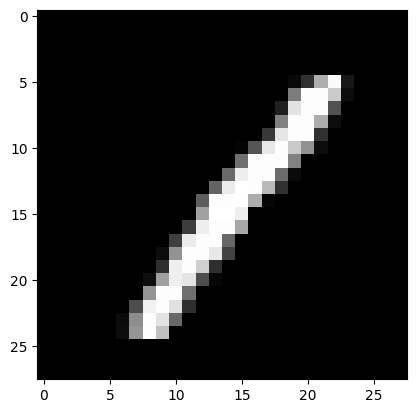

In [448]:
show_image(x, idx=3) # try different indices as well

Now display its reconstruction and compare:

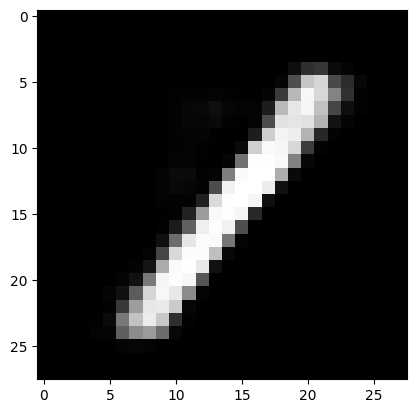

In [449]:
show_image(theta, idx=3)

### ***Step8: Generate images from noise***

In the previous step, we sampled latent vector $z$ from $q(z|x)$. However, we know that the KL term in our loss function enforced $q(z|x)$ to be close to $N(0, I)$. Therefore, we can sample $z$ directly from noise $N(0, I)$, and pass it to the decoder $p(x|z)$.



**Q8.1 (3 points)** Create images from noise and display.

In [ ]:
with torch.no_grad():
    # insert your code here to create images from noise (it is enough to create theta value for each pixel)
    for i in range(batch_size):
        generated_latent = torch.randn(batch_size, latent_dim)
        generated_images = model.Decoder(generated_latent)     
    # generated_images = ....  # should be a matrix ( batch_size-by-x_dim )

Display a couple of generated images:

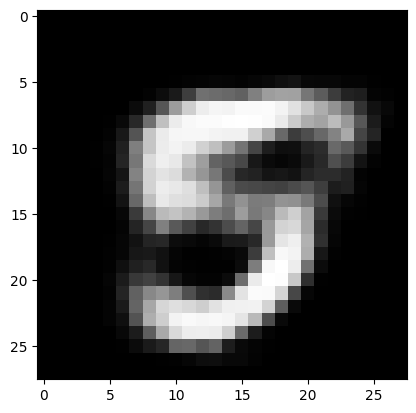

In [479]:
show_image(generated_images, idx=15)

### ***Step9: Latent representations***

Beside data generation, VAEs are also commonly used to obtain low-dimensional representations of data and these representations are then used for downstream tasks. In this section, you will visualize the latent representations learned by your model.

To this end, we will first project them to 2D using t-SNE:

In [480]:
from sklearn.manifold import TSNE
def get_2d_representations(z):
    tsne = TSNE()
    rep_2D = tsne.fit_transform(z)
    return rep_2D

In [489]:

x_test_array = np.array(x_test).reshape(10000,784)
z_test_array = np.array(z_test).reshape(10000,200)
# Project the latent representations of first 200 test data into 2D
rep_2d = get_2d_representations(z_test_array[:200,:])

Now, visualize the latent space in 2D and comment on the plot:

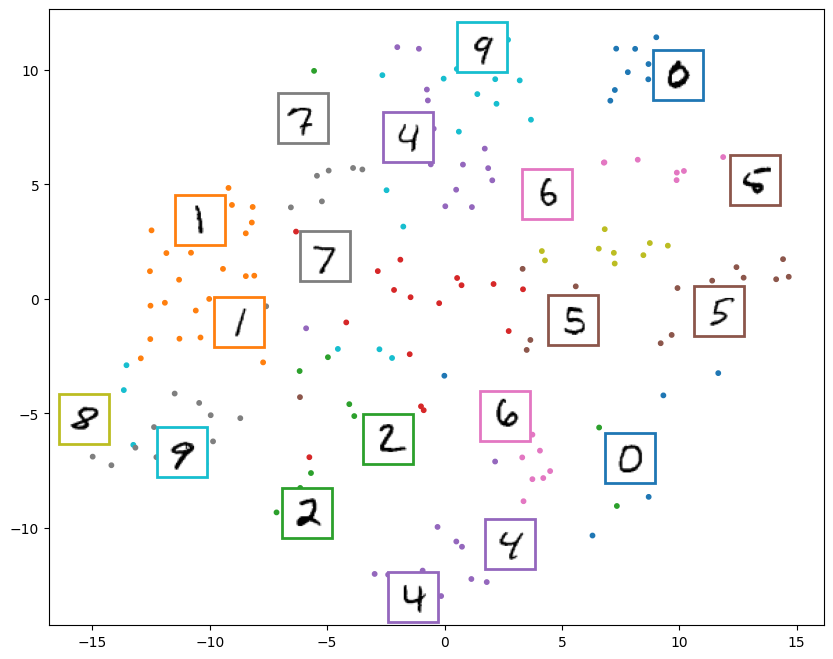

In [490]:
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
fig = plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(rep_2d[:, 0], rep_2d[:, 1], c=test_labels[:200], s=10, cmap=cmap)
image_positions = np.array([[1.0, 1.0]])
dist_coord1 = np.max(rep_2d[:, 0]) - np.min(rep_2d[:, 0])
dist_coord2 = np.max(rep_2d[:, 1]) - np.min(rep_2d[:, 1])
target_dist = np.sqrt(dist_coord1**2+dist_coord2**2)/2
for index, position in enumerate(rep_2d):
      dist = np.sum((position - image_positions) ** 2, axis=1)
      if np.min(dist) > target_dist:  # if far enough from other images
          image_positions = np.r_[image_positions, [position]]
          imagebox = AnnotationBbox(
              OffsetImage(x_test_array[index].reshape(28, 28), cmap="binary"),
              position,
              bboxprops={"edgecolor": tuple(cmap([test_labels[:200][index]])[0]), "lw": 2},
          )
          plt.gca().add_artist(imagebox)

**Q9.1 (1 point)** Comment on the learned latent representations.

.

.

.

### ***Step10: Disentangled Latent Space***
The KL term between the prior and the variational distributions often limits the latent representation capabilities of VAEs. One approach to overcome this problem is to use Maximum-Mean Discrepancy (MMD) instead of KL.

MMD is a framework to quantify the distance between two distributions by comparing all of their moments. It can be efficiently implemented using the kernel trick.  Letting $k(\cdot , \cdot)$ be any positive definite kernel, the
MMD between q and p is:
$D_{MMD}(q||p) = \mathbb{E}_{p(z),p(z')} \: \big[k(z,z')\big] - 2 \mathbb{E}_{q(z),p(z')}\: \big[k(z,z')\big] + \mathbb{E}_{q(z),q(z')}\: \big[k(z,z')\big]$

**Q10.1 (2 point)**  Below you are given an implementation of the RBF kernel.
Implement MMD using this kernel:

In [491]:
def compute_rbf(x1: torch.Tensor, x2: torch.Tensor, latent_var: float = 2.0, eps: float = 1e-7) -> torch.Tensor:
    """
    Computes the RBF Kernel between x1 and x2.
    :param x1: (Tensor)
    :param x2: (Tensor)
    :param eps: (Float)
    :return:
    """
    z_dim = x2.size(-1)
    sigma = (2.0 / z_dim) * latent_var

    result = torch.exp(-((x1 - x2).pow(2).mean(-1) / sigma))
    return result

In [493]:
def MMD(prior_z: torch.Tensor, z: torch.Tensor):
    # insert your code here
    #
    mmd_prior = compute_rbf(prior_z, prior_z)
    mmd_comb = compute_rbf(prior_z,z)
    mmd = compute_rbf(z,z)
    mmd_tot = mmd.mean() - 2 * mmd_comb.mean() + mmd_prior.mean()
    return mmd_tot

**Q10.2 (2 point)** Now, define a new loss function which involves MMD instead of KL:

In [498]:
from torch.optim import Adam
def loss_mmd (x, theta, z):
    MMD_loss = MMD(x,theta)
    MC_loss = torch.sum(x * torch.log(theta + 1e-8) + (1 - x) * torch.log(1 - theta + 1e-8))
    loss = + MMD_loss - MC_loss
    return loss


We can initialize another model and train it using the new loss:

In [499]:
encoder_2 = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder_2 = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
# new model
model_2 = Model(Encoder=encoder_2, Decoder=decoder_2)
# its optimizer
optimizer_2 = Adam(model_2.parameters(), lr=lr)

In [500]:
print("Start training VAE...")
model_2.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = torch.round(x)

        optimizer_2.zero_grad()

        theta_2, mean_2, log_var_2, z_2 = model_2(x)
        loss_2 = loss_mmd(x, theta_2, z_2)

        overall_loss += loss_2.item()

        loss_2.backward()
        optimizer_2.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  120.01343150856897
	Epoch 2 complete! 	Average Loss:  57.618201233827214
	Epoch 3 complete! 	Average Loss:  44.661085427209414
	Epoch 4 complete! 	Average Loss:  38.51872666602541
	Epoch 5 complete! 	Average Loss:  34.30527344565161
Finish!!


**Q10.3 (1 point)** Implement the function below to obtain the latent representations of test set.

In [501]:
model_2.eval()
with torch.no_grad():
    z_test = []
    x_test = []
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x_test.append(x)
        z, _ = model.Encoder(x) # insert your code here
        z = z.view(batch_size, latent_dim)
        z_test.append(z)
        theta = model.Decoder(z)# insert your code here

100%|██████████| 100/100 [00:00<00:00, 154.35it/s]


Now, project the learned latent representations into 2D and visualize them:

In [503]:
z_test_array = np.array(z_test).reshape(10000,200)
x_test_array = np.array(x_test).reshape(10000,784)
rep_2d = get_2d_representations(z_test_array[:200,:])

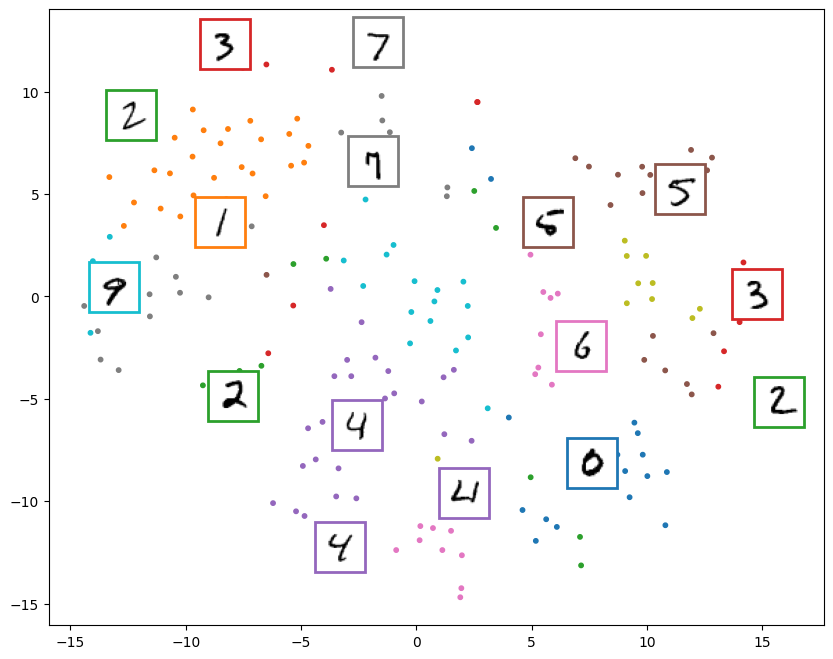

In [504]:
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
fig = plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(rep_2d[:, 0], rep_2d[:, 1], c=test_labels[:200], s=10, cmap=cmap)
image_positions = np.array([[1.0, 1.0]])
dist_coord1 = np.max(rep_2d[:, 0]) - np.min(rep_2d[:, 0])
dist_coord2 = np.max(rep_2d[:, 1]) - np.min(rep_2d[:, 1])
target_dist = np.sqrt(dist_coord1**2+dist_coord2**2)/1.5
for index, position in enumerate(rep_2d):
      dist = np.sum((position - image_positions) ** 2, axis=1)
      if np.min(dist) > target_dist:  # if far enough from other images
          image_positions = np.r_[image_positions, [position]]
          imagebox = AnnotationBbox(
              OffsetImage(x_test_array[index].reshape(28, 28), cmap="binary"),
              position,
              bboxprops={"edgecolor": tuple(cmap([test_labels[:200][index]])[0]), "lw": 2},
          )
          plt.gca().add_artist(imagebox)

**Q10.4 (2 point)** Analyze the plot and compare the latent representations obtained when using a loss function with Maximum Mean Discrepancy (MMD) against those obtained with a loss function involving the Kullback-Leibler (KL) divergence. Highlight the key differences between the two approaches and discuss scenarios where latent representations learned with MMD would be more advantageous. Provide concrete examples to these cases.

.

.

.
